<a href="https://colab.research.google.com/github/siddharthdhara/Pytorch-Practice-/blob/main/CV_Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
      Successfully uninstalled scipy-1.11.2
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
     

**Image Classification (CIFAR-10) on Kaggle**

In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
#Obtaining Dataset

d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip','2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
demo = True
if demo:
  data_dir = d2l.download_extract('cifar10_tiny')
else:
  data_dir = '../data/cifar-10/'

In [ ]:
#Organizing the dataset
def read_csv_labels(fname):
  with open(fname, 'r') as f:
    lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))


# training examples: 1000
# classes: 10


In [ ]:
#split validation set from original training dataset

def copyfile(filename, target_dir):
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
  n = collections.Counter(labels.values()).most_common()[-1][1]
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_file.split('.')[0]]
    fname = os.path.join(data_dir, 'train', train_file)
    copyfile(fname, os.path.join(data_dir, 'train_valid_test','train_valid', label))
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test','valid', label))
      label_count[label] = label_count.get(label, 0) + 1
    else:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test','train', label))
  return n_valid_per_label

In [ ]:
# now organize the testing set for data loading during prediction

def reorg_test(data_dir):
  for test_file in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(os.path.join(data_dir, 'test', test_file),
             os.path.join(data_dir, 'train_valid_test', 'test','unknown'))

In [ ]:
#invoking or calling the functions defined above

def reorg_cifar10_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
  reorg_train_valid(data_dir, labels, valid_ratio)
  reorg_test(data_dir)

In [ ]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [ ]:
#now we use image augmentation to address overfitting

transform_train = torchvision.transforms.Compose([torchvision.transforms.Resize(40),torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
ratio=(1.0, 1.0)),torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ToTensor(),
# Standardize each channel of the image
torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

In [ ]:
#standardize to remove any randomness in evaulation results

transform_test = torchvision.transforms.Compose([
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
[0.2023, 0.1994, 0.2010])])

In [ ]:
# now we read the organized dataset consisting of raw image files

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                             transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                      transform=transform_test) for folder in ['valid', 'test']]

In [ ]:
#now we specify all the image augmentation operations defined above

train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

In [ ]:
#defining the model

def get_net():
  num_classes = 10
  net = d2l.resnet18(num_classes, 3)
  return net

loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
#defining the training function

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.633, train acc 0.779, valid acc 0.328
624.1 examples/sec on [device(type='cuda', index=0)]


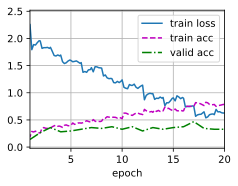

In [ ]:
#training and validating the model

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.596, train acc 0.773
1054.5 examples/sec on [device(type='cuda', index=0)]


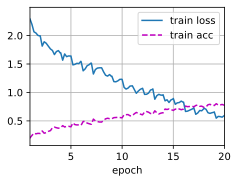

In [ ]:
#classifying the Testing Set
net, preds = get_net(), []
net(next(iter(train_valid_iter))[0])
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

**Dog Breed Identification (ImageNet Dogs)**

In [ ]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
#Obtaining the Dataset

d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip','0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')
demo = True
if demo:
  data_dir = d2l.download_extract('dog_tiny')
else:
  data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [ ]:
#Organizing the dataset

def reorg_dog_data(data_dir, valid_ratio):
  labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
  d2l.reorg_train_valid(data_dir, labels, valid_ratio)
  d2l.reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [ ]:
#image augmentation for training dataset

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),ratio=(3.0/4.0, 4.0/3.0)),
                                                  torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ColorJitter(brightness=0.4,
                                                  contrast=0.4,saturation=0.4),torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
#Image augmentation for the test dataset

transform_test = torchvision.transforms.Compose([torchvision.transforms.Resize(256),torchvision.transforms.CenterCrop(224),
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
#reading the dataset

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                             transform=transform_train) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                      transform=transform_test) for folder in ['valid', 'test']]

In [ ]:
#creating data iterator instances

train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)


In [ ]:
#fine-tuning a pre-trained model

def get_net(devices):
  finetune_net = nn.Sequential()
  finetune_net.features = torchvision.models.resnet34(pretrained=True)
  finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),nn.ReLU(),nn.Linear(256, 120))
  finetune_net = finetune_net.to(devices[0])
  for param in finetune_net.features.parameters():
    param.requires_grad = False
    return finetune_net


In [ ]:
#obtaining the input of the pretrained model's output layer, i.e., the extracted feature and then use this to calculate loss

loss = nn.CrossEntropyLoss(reduction='none')
def evaluate_loss(data_iter, net, devices):
  l_sum, n = 0.0, 0
  for features, labels in data_iter:
    features, labels = features.to(devices[0]), labels.to(devices[0])
    outputs = net(features)
    l = loss(outputs, labels)
    l_sum += l.sum()
    n += labels.numel()
    return l_sum / n


In [ ]:
#define the training function

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.659, valid loss 1.332
224.0 examples/sec on [device(type='cuda', index=0)]


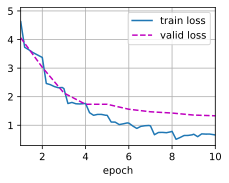

In [ ]:
#training and validating the model

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.712
222.6 examples/sec on [device(type='cuda', index=0)]


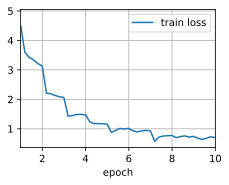

In [ ]:
#Classifying the Testing Set

net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')